In [93]:
from sklearn.manifold import SpectralEmbedding
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from scipy import stats
from sklearn.feature_selection import SelectKBest, f_regression, chi2
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.feature_selection import mutual_info_classif


In [131]:
def split_labels(df, cols):
    '''split the dataframe into predicting table and labels
       df: given dataset
       cols: list of labels
    '''
    return df[[i for i in df if i not in cols]], df[cols]

def kNN(X_train,y_train, X_test):
#     print('implementing kNN...')
    from sklearn.neighbors import KNeighborsClassifier

    # assuming X is your data and k is the number of clusters
    clf = KNeighborsClassifier(n_neighbors=10)
    clf.fit(X_train, y_train)
    return clf.predict(X_test)

def Logistic(X_train,y_train, X_test):
    clf = LogisticRegression(max_iter=10000, penalty='l1', C=1.6, solver= 'liblinear')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)    
    return y_pred

   
def CART(X_train,y_train, X_test):
    clf = DecisionTreeClassifier(max_depth=5)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return y_pred

def one_split(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
    return X_train, X_test, y_train, y_test 

def get_classification_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]
    sensitivity = []
    specificity = []
    for i in range(num_classes):
        tp = cm[i,i]
        fn = np.sum(cm[i,:]) - tp
        fp = np.sum(cm[:,i]) - tp
        tn = np.sum(cm) - tp - fp - fn
        
        sensitivity_i = tp / (tp + fn)
        specificity_i = tn / (tn + fp)
        sensitivity.append(sensitivity_i)
        specificity.append(specificity_i)
    
    macro_sensitivity = np.mean(sensitivity)
    macro_specificity = np.mean(specificity)
    
    return accuracy, macro_sensitivity, macro_specificity

def predict(X,Y, predictors):
    X_train, X_test, y_train, y_test = one_split(X, Y)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    pred_Y = [pred(X_train, np.ravel(y_train), X_test) for pred in predictors]
    return [get_classification_metrics(y_test, p) for p in pred_Y]

def PCA_model(X, n = 2):
    pca = PCA(n_components=n)
    pca.fit(X)
    X_pca = pca.transform(X)
    return X_pca

def SE_rbf(X, n=2):
    sigma = 0.1
    se = SpectralEmbedding(n_components=n, affinity='rbf', n_neighbors=30, gamma=1 / (2 * sigma ** 2))
    X_CE = se.fit_transform(X)
    return X_CE

def SE_nn(X, n=2):
    se = SpectralEmbedding(n_components=n, affinity='nearest_neighbors', n_neighbors=50, eigen_solver='arpack')
    X_CE = se.fit_transform(X)
    return X_CE

# -------------------------------------------------------------------
predictors = [CART, Logistic]
predictorsTXT = ['CART', 'Logistic']
# -------------------------------------------------------------------
DR = [ PCA_model, SE_rbf, SE_nn]
DR_TXT = [ 'PCA_model','SE_rbf', 'SE_nn']

# Dataset1

In [132]:
df1 = pd.read_csv('heart.csv')

# Preprocessing
dataset = df1
from pandas import get_dummies
a = pd.get_dummies(dataset['sex'], prefix = "sex")
b = pd.get_dummies(dataset['cp'], prefix = "cp")
c = pd.get_dummies(dataset['fbs'], prefix = "fbs")
d = pd.get_dummies(dataset['restecg'], prefix = "restecg")
e = pd.get_dummies(dataset['exang'], prefix = "exang")
f = pd.get_dummies(dataset['slope'], prefix = "slope")
g = pd.get_dummies(dataset['ca'], prefix = "ca")
h = pd.get_dummies(dataset['thal'], prefix = "thal")

frames = [dataset, a, b, c, d, e, f, g, h]
dataset2 = pd.concat(frames, axis = 1)
dataset2 = dataset2.drop(columns = ['sex','cp', 'fbs', 'restecg','exang','slope','ca','thal'])

df1 = dataset2
X1, Y1 = split_labels(df1, ['target'])

## Dataset1 - PCA 

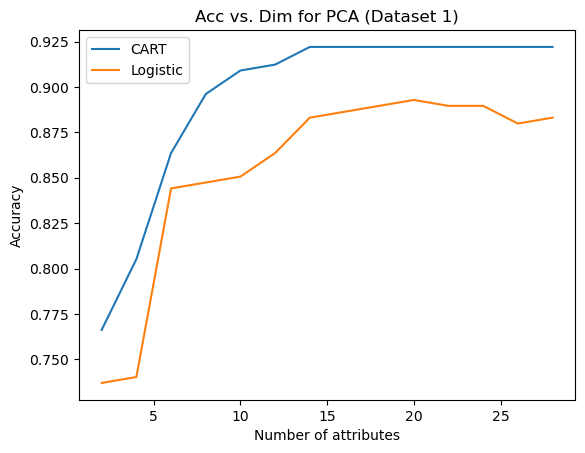

In [133]:
# Doing PCA...
All = {}
for NoF in range (2, X1.shape[1], 2): # Number of features
    X1s = PCA_model(X1, NoF) # dimension reduction
    results1 = predict(X1s, np.ravel(Y1), predictors) # Machine learning models
    
    All[NoF] = [results1[0][0], results1[1][0]]

num = [f for f in All]
cart = [All[f][0] for f in All]
logistic = [All[f][1] for f in All]
fdf = pd.DataFrame({'Number of attributes': num, 
                    'CART': cart,
                    'Logistic': logistic})
# -------------------------------------------------------------------
import matplotlib.pyplot as plt
fdf.plot(x='Number of attributes', y=['CART', 'Logistic'])
plt.legend()
plt.ylabel('Accuracy')
plt.title("Acc vs. Dim for PCA (Dataset 1)")
plt.show()

## Dataset1 - Spectral embedding

In [136]:
X1, Y1 = split_labels(df1, ['target'])
All_nn = {}
print(X1.shape[1])
X_train, X_test, y_train, y_test = one_split(X1, Y1)
SE = SE_nn
for NoF in range (2, X1.shape[1], 2): # Number of features
    # calculate the embedding representation of the train dataset
    X_train_SE = SE(X_train, NoF)
   
    X_test_SE_nn = pd.DataFrame(columns=[i for i in range(NoF)])
    # take one datapoint and find its embedding and adding it to new embedded test set
    for _, row in X_test.iterrows():
        X_tr = X_train.copy()
        X_tr.loc[len(X_tr)] = row
        
        X_tr_SE_nn = SE(X_tr, NoF)
        
        nn = X_tr_SE_nn[-1]
        X_test_SE_nn.loc[len(X_test_SE_nn)] = nn

    scaler = StandardScaler()
    X_train_SE = scaler.fit_transform(X_train_SE)
    
    X_test_nn = scaler.transform(X_test_SE_nn)
    
    pred_Y_nn = [pred(X_train_SE, np.ravel(y_train), X_test_nn) for pred in predictors]
    results_nn = [get_classification_metrics(y_test, p) for p in pred_Y_nn]

    All_nn[NoF] = [results_nn[0][0], results_nn[1][0]]
    print(NoF, results_nn[0][0], results_nn[1][0])
print('Spectral embedding nn')



30
2 0.672077922077922 0.6006493506493507
4 0.7597402597402597 0.7077922077922078
6 0.737012987012987 0.7142857142857143
8 0.7207792207792207 0.711038961038961
10 0.698051948051948 0.7175324675324676
12 0.711038961038961 0.711038961038961
14 0.7077922077922078 0.7207792207792207
16 0.7175324675324676 0.7402597402597403
18 0.7012987012987013 0.7272727272727273
20 0.7077922077922078 0.7467532467532467
22 0.6688311688311688 0.7467532467532467
24 0.672077922077922 0.7175324675324676
26 0.6818181818181818 0.711038961038961
28 0.6785714285714286 0.7012987012987013
Spectral embedding nn


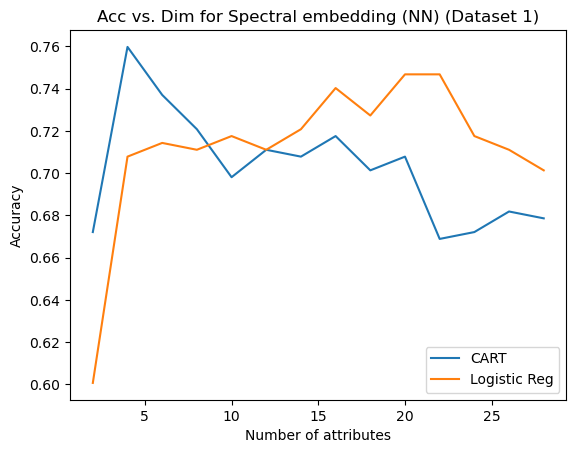

In [137]:
All = All_nn
num = [f for f in All]
cart = [All[f][0] for f in All]
logistic = [All[f][1] for f in All]
fdf = pd.DataFrame({'Number of attributes': num, 
                    'CART': cart,
                    'Logistic Reg': logistic})
# -------------------------------------------------------------------
import matplotlib.pyplot as plt
fdf.plot(x='Number of attributes', y=['CART', 'Logistic Reg'])
plt.legend()
plt.ylabel('Accuracy')
plt.title("Acc vs. Dim for Spectral embedding (NN) (Dataset 1)")
plt.show()